## Multi-class Classification 

We will see an example on iris data classification. The notebook is modified from [Yale S&DS 265].

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

The following cell plots the original data in terms of sepal and petal dimensions.

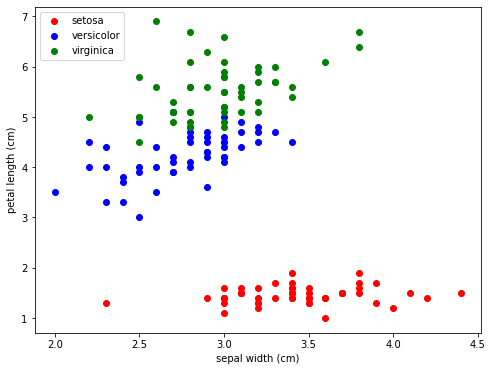

In [ ]:
from sklearn.datasets import load_iris

fig = plt.figure(figsize=(8,6))
iris = load_iris()
x_index = 1
y_index = 2
ax = fig.add_subplot(111)
colors = ['red', 'blue', 'green']

# Mapping each categorical variable to a series of 1-hot or "dummy" variables, so the weights are meaningful in a logistic regression model.
for c in np.arange(3):
    mask = (iris.target==c)
    plt.scatter(iris.data[mask, x_index], iris.data[mask, y_index], color=colors[c], label=iris.target_names[c])

plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index])
plt.legend(loc='upper left')
plt.show()

#### Training logistic regression models

We'll construct a series of logistic regression models using an increasing number of training points. 
Specifically, we will

* let the sample size 10% of the data to 90% of the data, in increments of 10%
* for each sample size, train a logistic regression model on randomly selected training points, and test on the remaining data
* For each sample size, run 1000 trials and average the error rates
* Plot the resulting average error rates as a function of sample percentage of the data

Some notes:

* As before, we will use the function sklearn.model_selection.train_test_split in each trial to randomly split the data into training and test sets. For example, you can use train_test_split(X, y, train_size=.1)
* We now use `lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')` to fit a logistic regression model to predict the three class labels (*versicolor*, *virginica*, and *setosa*). This is a linear model of the log-odds, just as for binary logistic regression. The decision boundaries will be linear functions of the four predictor variables.
* In a little more detail, in a logistic regression model to carry out three-way classification where $Y$ can be 0, 1, or 2, the model takes the form
$$ P(Y=0 \,|\, x) = \frac{1}{1 + e^{\beta_1^T x} + e^{\beta_2^T x}}$$
<br>
$$ P(Y=1 \,|\, x) = \frac{e^{\beta_1^T x}}{1 + e^{\beta_1^T x} + e^{\beta_2^T x}}$$
<br>
$$ P(Y=2 \,|\, x) = \frac{e^{\beta_2^T x}}{1 + e^{\beta_1^T x} + e^{\beta_2^T x}}$$
<br>
* The decision boundaries between any two classes in such a model are linear.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import pdb

X = iris.data
y = iris.target

pdb.set_trace()

lr = LogisticRegression(penalty='l2', C=.1, multi_class='multinomial')
lr_error_rate = []
trials = 100
train_percent = np.linspace(.1,.9,num=9)

# your code here
from tqdm import tqdm
for p in tqdm(train_percent):
    errs = []
    for trial in np.arange(trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=p)
        lr.fit(X_train, y_train)
        err = np.mean(lr.predict(X_test) != y_test)
        errs.append(err)
    this_err = np.mean(errs)
    lr_error_rate.append(this_err)
    
plt.plot(train_percent, lr_error_rate)
plt.xlabel('train percent')
_ = plt.ylabel('error')


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/bdb.py", line 332, in set_trace
    sys.settrace(self.trace_dispatch)



--Return--
> <ipython-input-8-ecfe7eb80818>(9)<module>()->None
-> pdb.set_trace()


#### Finding the minimum error

What is the smallest average error attained by logistic regression?

In [ ]:
min_error = np.min(np.array(lr_error_rate)) 
print("The minimum error attained by the logistic regression is %.2f%%" % (100*min_error))

The minimum error attained by the logistic regression is 4.93%


##Cross Validation

In this notebook we'll illustrate leave-one-out cross validation using the California housing data. First import the usual packages. We'll also use the seaborn package for visualization -- this has some nice functions that you might want to explore. 



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# import data
from sklearn.datasets import fetch_california_housing
ca_housing = fetch_california_housing()
print(ca_housing.DESCR)
california = pd.DataFrame(ca_housing.data, columns=ca_housing.feature_names)
california['MedValue'] = ca_housing.target
california.head()

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


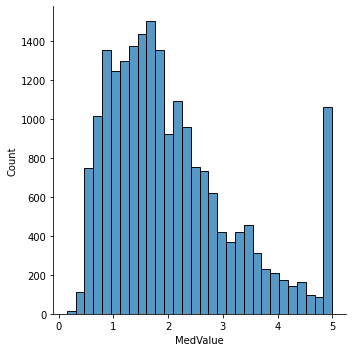

In [ ]:
_ = sns.displot(california['MedValue'], bins=30)

Let's look at pairs of selected variables. We'll restrict to the first 1000 entries for efficiency.

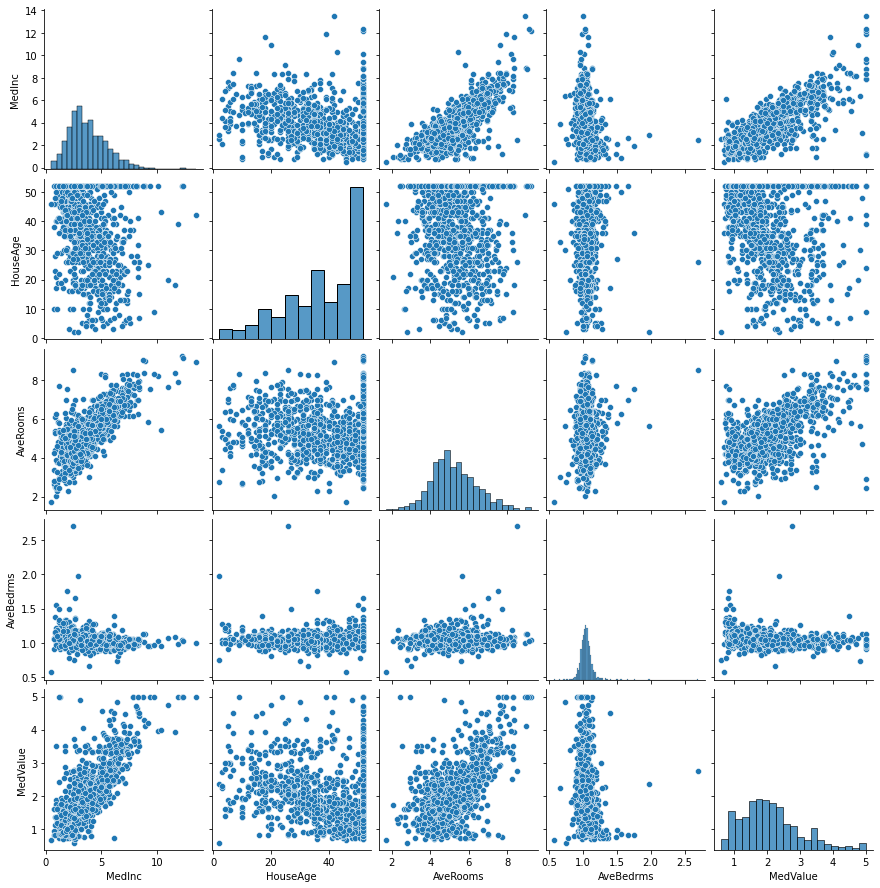

In [ ]:
cali = california.head(1000)
cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'MedValue']
sns_plot = sns.pairplot(cali[cols])
sns_plot.savefig("ca_pairplot.png")

We'll now compare three models, using the variable 'MedInc', adding 'AveRooms' and then adding 'HouseAge'

In [ ]:
X1 = pd.DataFrame()
X1['MedInc'] = cali['MedInc']
X1 = sm.add_constant(X1) 

X2 = X1.copy()
X2['AveRooms'] = cali['AveRooms']

X3 = X2.copy()
X3['HouseAge'] = cali['HouseAge']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


First we'll run cross-validation by taking random training/test splits and averaging the test errors.

 Model 1: 0.327339
 Model 2: 0.332614
 Model 3: 0.326867


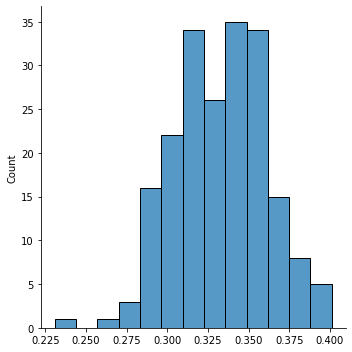

In [ ]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

y = cali['MedValue']

error1 = []
error2 = []
error3 = []
trials = 200

for trial in np.arange(trials):
    X_train, X_test, y_train, y_test = train_test_split(X1, y, train_size=.50)
    model = sm.OLS(y_train, X_train).fit()
    error1.append(np.mean((y_test - model.predict(X_test))**2))

    X_train, X_test, y_train, y_test = train_test_split(X2, y, train_size=.50)
    model = sm.OLS(y_train, X_train).fit()
    error2.append(np.mean((y_test - model.predict(X_test))**2))

    X_train, X_test, y_train, y_test = train_test_split(X3, y, train_size=.50)
    model = sm.OLS(y_train, X_train).fit()
    error3.append(np.mean((y_test - model.predict(X_test))**2))

print(" Model 1: %f\n Model 2: %f\n Model 3: %f" % (np.mean(error1), np.mean(error2), np.mean(error3)))

sns_plot = sns.displot(error2)
sns_plot.savefig("ca_error2.png")

Now let's compute leave-one-out cross-validation scores for the three models. Note that this doesn't require any splitting of the data into test and training, we simply fit a single model on all of the data.

In [ ]:
H1 = np.dot(X1, np.dot(np.linalg.inv(np.dot(X1.T, X1)), X1.T))
yhat = np.dot(H1, y)
loocv1 = np.mean((y-yhat)**2/(1-np.diag(H1))**2)


H2 = np.dot(X2, np.dot(np.linalg.inv(np.dot(X2.T, X2)), X2.T))
yhat = np.dot(H2, y)
loocv2 = np.mean((y-yhat)**2/(1-np.diag(H2))**2)


H3 = np.dot(X3, np.dot(np.linalg.inv(np.dot(X3.T, X3)), X3.T))
yhat = np.dot(H3, y)
loocv3 = np.mean((y-yhat)**2/(1-np.diag(H3))**2)

print(" Model 1 LOOCV: %f\n Model 2 LOOCV: %f\n Model 3 LOOCV: %f" % (loocv1, loocv2, loocv3))

 Model 1 LOOCV: 0.328007
 Model 2 LOOCV: 0.328799
 Model 3 LOOCV: 0.325303


For comparison, let's see what the LOOCV score is if we include all of the variables (9 total)

In [ ]:
X = cali.drop('MedValue', axis=1)
X = sm.add_constant(X)
y = cali['MedValue']
model = sm.OLS(y, X).fit()
H = np.dot(X, np.dot(np.linalg.inv(np.dot(X.T, X)), X.T))
yhat = np.dot(H, y)
loocv = np.mean((y-yhat)**2/(1-np.diag(H))**2)
# check that we get the same result with the predicted values
loocv2 = np.mean((y-model.predict(X))**2/(1-np.diag(H))**2)

print(loocv)
print(loocv2)


0.29614115700978416
0.296141157017519


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
